<a href="https://colab.research.google.com/github/mba-fabio/dsa_usp/blob/main/20250420_Resultados_Preliminares_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Otimização da Distribuição de Joias e Relógios de Luxo Usados: Modelos Preditivos no mercado de luxo “Second Hand”

##Instalações e importações de pacotes

In [55]:
!pip install pulp

import pandas as pd
import pulp


## Importação de dados do Github

###Estoque Atual de cada loja

In [57]:
# Carrega os dados de estoque para o Data Frame do Pandas
estoque_joias = pd.read_csv('https://github.com/mba-fabio/dsa_usp/raw/main/20250330_estoque_joias.csv')
estoque_joias.info()
print(estoque_joias.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Localizacao_Loja  1900 non-null   object 
 1   Tipo_Joia         1900 non-null   object 
 2   Marca             1900 non-null   object 
 3   Tipo_Ouro         1900 non-null   object 
 4   Tipo_Pedra        1900 non-null   object 
 5   Preço             1900 non-null   float64
dtypes: float64(1), object(5)
memory usage: 89.2+ KB
  Localizacao_Loja Tipo_Joia                Marca     Tipo_Ouro  \
0       Shopping A  Pingente  Marca Internacional   ouro branco   
1       Shopping A     Colar            Sem Marca  ouro amarelo   
2       Shopping A  Pulseira            Sem Marca   ouro branco   
3       Shopping A  Pingente       Marca Nacional  ouro amarelo   
4       Shopping A    Brinco  Marca Internacional     ouro rosé   

      Tipo_Pedra   Preço  
0      sem pedra  1200.0  
1      e

###Histórico de vendas dos últimos 24 meses

In [58]:
# Carrega os dados de venda para o Data Frame do Pandas
vendas24m = pd.read_csv('https://github.com/mba-fabio/dsa_usp/raw/main/20250331_joias_simuladas_historico_24meses_sazonal.csv')
vendas24m.info()
print(vendas24m.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9560 entries, 0 to 9559
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Data              9560 non-null   object 
 1   Tipo_Joia         9560 non-null   object 
 2   Tipo_Ouro         9560 non-null   object 
 3   Tipo_Pedra        9560 non-null   object 
 4   Marca             9560 non-null   object 
 5   Localizacao_Loja  9560 non-null   object 
 6   Perfil_Cliente    9560 non-null   object 
 7   Preco             9560 non-null   float64
dtypes: float64(1), object(7)
memory usage: 597.6+ KB
      Data Tipo_Joia     Tipo_Ouro Tipo_Pedra                Marca  \
0  2022-01     Colar  Ouro Amarelo  Sem Pedra  Marca Internacional   
1  2022-01      Anel     Ouro Rosé  Sem Pedra  Marca Internacional   
2  2022-01    Brinco     Ouro Rosé  Sem Pedra  Marca Internacional   
3  2022-01  Corrente   Ouro Branco  Sem Pedra       Marca Nacional   
4  2022-01    Brinco

###Lote para distribuição entre lojas

In [84]:
# Carrega os dados do lote atual para o Data Frame do Pandas
lote = pd.read_csv('https://github.com/mba-fabio/dsa_usp/raw/main/20250405_Lote_Distribuicao_v3_desbalanceado.csv')
lote.info()
print(lote.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tipo_Joia   110 non-null    object 
 1   Tipo_Ouro   110 non-null    object 
 2   Tipo_Pedra  110 non-null    object 
 3   Marca       110 non-null    object 
 4   Preco       110 non-null    float64
dtypes: float64(1), object(4)
memory usage: 4.4+ KB
  Tipo_Joia     Tipo_Ouro     Tipo_Pedra                Marca   Preco
0    Brinco  Ouro Amarelo      Sem Pedra       Marca Nacional  2080.0
1    Brinco   Ouro Branco      Sem Pedra  Marca Internacional  3900.0
2    Brinco  Ouro Amarelo           Rubi       Marca Nacional  5200.0
3    Brinco   Ouro Branco  Outras Pedras  Marca Internacional  8580.0
4    Brinco  Ouro Amarelo       Diamante       Marca Nacional  8320.0


###Capacidade de estoque máxima de cada loja

In [89]:
# Carrega os dados de capacidade máxima de estoque de cada loja para o Data Frame do Pandas
capacidade_lojas = pd.read_csv('https://github.com/mba-fabio/dsa_usp/raw/main/20250419_Capacidade_Estoque_Lojas.csv')
capacidade_lojas.info()
print(capacidade_lojas.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Localizacao_Loja  4 non-null      object
 1   Estoque_Maximo    4 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 196.0+ bytes
  Localizacao_Loja  Estoque_Maximo
0       Shopping A             740
1       Shopping B             570
2       Shopping C             490
3       Shopping D             410


In [93]:
# 1. Calcular demanda média mensal por tipo de joia e loja
vendas_por_joia = vendas24m.groupby(['Localizacao_Loja', 'Tipo_Joia', 'Tipo_Ouro', 'Tipo_Pedra', 'Marca', 'Preco']).size()
vendas_por_joia = (vendas_por_joia / 24).reset_index(name='vendas_media_mes')

vendas_por_joia

# 2. Combinar com estoque atual para calcular "urgência"
urgencia = pd.merge(
    vendas_por_joia,
    estoque_joias.groupby(['Localizacao_Loja', 'Tipo_Joia', 'Tipo_Ouro', 'Tipo_Pedra', 'Marca']).size().reset_index(name='estoque_atual'),
    on=['Localizacao_Loja', 'Tipo_Joia', 'Tipo_Ouro', 'Tipo_Pedra', 'Marca'],
    how='left'
)
urgencia['estoque_atual'] = urgencia['estoque_atual'].fillna(0)
urgencia['urgencia'] = urgencia['vendas_media_mes'] - urgencia['estoque_atual']

# 3. Preparar dados para otimização
lote_features = lote[['Tipo_Joia', 'Tipo_Ouro', 'Tipo_Pedra', 'Marca', 'Preco']].drop_duplicates()
lojas = capacidade_lojas['Localizacao_Loja'].tolist()

# 4. Criar modelo de otimização
modelo = pulp.LpProblem("Distribuicao_Joias", pulp.LpMaximize)

# Variáveis de decisão: quantidade de cada joia alocada a cada loja
alocacao = pulp.LpVariable.dicts(
    "aloc",
    [(idx, loja) for idx in lote_features.index for loja in lojas],
    lowBound=0,
    cat='Integer'
)

# Função objetivo: maximizar a urgência total
modelo += pulp.lpSum(
    alocacao[(idx, loja)] * urgencia.loc[
        (urgencia['Localizacao_Loja'] == loja) &
        (urgencia['Tipo_Joia'] == lote_features.loc[idx, 'Tipo_Joia']) &
        # ... (adicionar todas as colunas de features aqui),
        'urgencia'
    ].values[0]
    for idx in lote_features.index for loja in lojas
)

# Restrições: capacidade máxima e não exceder o lote
for loja in lojas:
    capacidade = capacidade_lojas.loc[capacidade_lojas['Localizacao_Loja'] == loja, 'capacidade_max'].values[0]
    estoque_atual = estoque_joias.loc[estoque_joias['Localizacao_Loja'] == loja].shape[0]
    modelo += pulp.lpSum(alocacao[(idx, loja)] for idx in lote_features.index) <= (capacidade - estoque_atual)

for idx in lote_features.index:
    modelo += pulp.lpSum(alocacao[(idx, loja)] for loja in lojas) <= lote.loc[idx, 'quantidade']  # Supondo coluna 'quantidade'

# Resolver o modelo
modelo.solve()

# 5. Recuperar a alocação ótima
alocacao_final = []
for (idx, loja), var in alocacao.items():
    if var.varValue > 0:
        alocacao_final.append({
            **lote_features.loc[idx].to_dict(),
            'Localizacao_Loja': loja,
            'quantidade': var.varValue
        })

df_alocacao = pd.DataFrame(alocacao_final)
print(df_alocacao)





Distribuicao_Joias:
MAXIMIZE
None
VARIABLES

<ipython-input-26-9e5e058ccbcc>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(vendas_por_joia, x='Preco', y='Tipo_Pedra', inner='box', palette='Dark2')


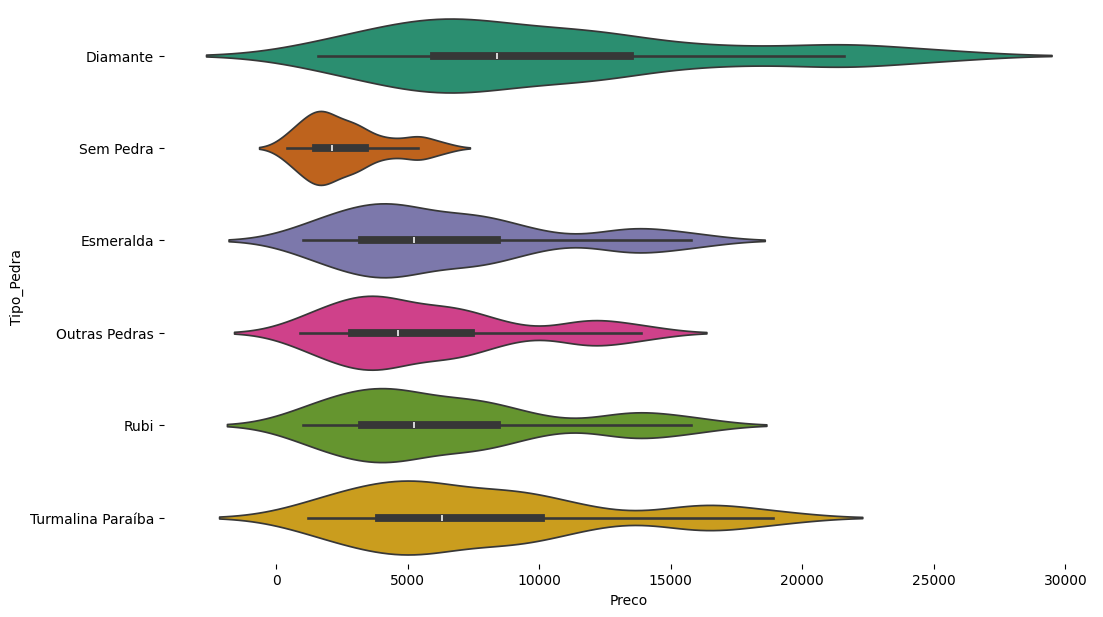

In [ ]:
# @title Tipo_Pedra vs Preco

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(vendas_por_joia['Tipo_Pedra'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(vendas_por_joia, x='Preco', y='Tipo_Pedra', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)